In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import concurrent.futures as cf

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from keras.preprocessing import image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.utils as nn_utils

from sklearn.preprocessing import StandardScaler

import gc

from IPython.display import clear_output

from matplotlib import pyplot as plt

## Read Metadata

In [2]:
def assign_class(x):
    x = str(x)
    if len(x) == 4:
        return 0
    elif len(x) == 5:
        return 1
    else:
        return 2

instagram_df = pd.read_csv('instagram_data.csv')
instagram_df['image_path'] = instagram_df['image_path'].str.replace('../Data/', '')
instagram_df["class"] = instagram_df["likes"].apply(lambda x: assign_class(x))
instagram_df

,likes,no_of_comments,t,follower_count_at_t,image_path,class
0,154552,0,1594174009,40934474,insta_data/0.jpg,2
1,97386,0,1593571666,40934474,insta_data/2.jpg,1
2,145632,0,1593136341,40934474,insta_data/4.jpg,2
3,76461,0,1592981047,40934474,insta_data/6.jpg,1
4,174620,0,1592703461,40934474,insta_data/8.jpg,2
...,...,...,...,...,...,...
3780,341895,6029,1555164674,4229627,insta_data/9435.jpg,2
3781,217095,2591,1554706282,4229627,insta_data/9436.jpg,2
3782,17902,253,1553945996,4229627,insta_data/9437.jpg,1
3783,141694,1175,1552645088,4229627,insta_data/9442.jpg,2


In [3]:
likes_upper_bound = instagram_df['likes'].quantile(0.9)
comments_upper_bound = instagram_df['no_of_comments'].quantile(0.9)
t_lower_bound = instagram_df['t'].quantile(0.1)
new_instagram_df = instagram_df[(instagram_df['likes'] < likes_upper_bound) & (instagram_df['no_of_comments'] < comments_upper_bound) & (instagram_df['t'] > t_lower_bound)]

In [4]:
print(new_instagram_df['class'].value_counts())

class
2    1453
1    1378
0     124
Name: count, dtype: int64


c:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

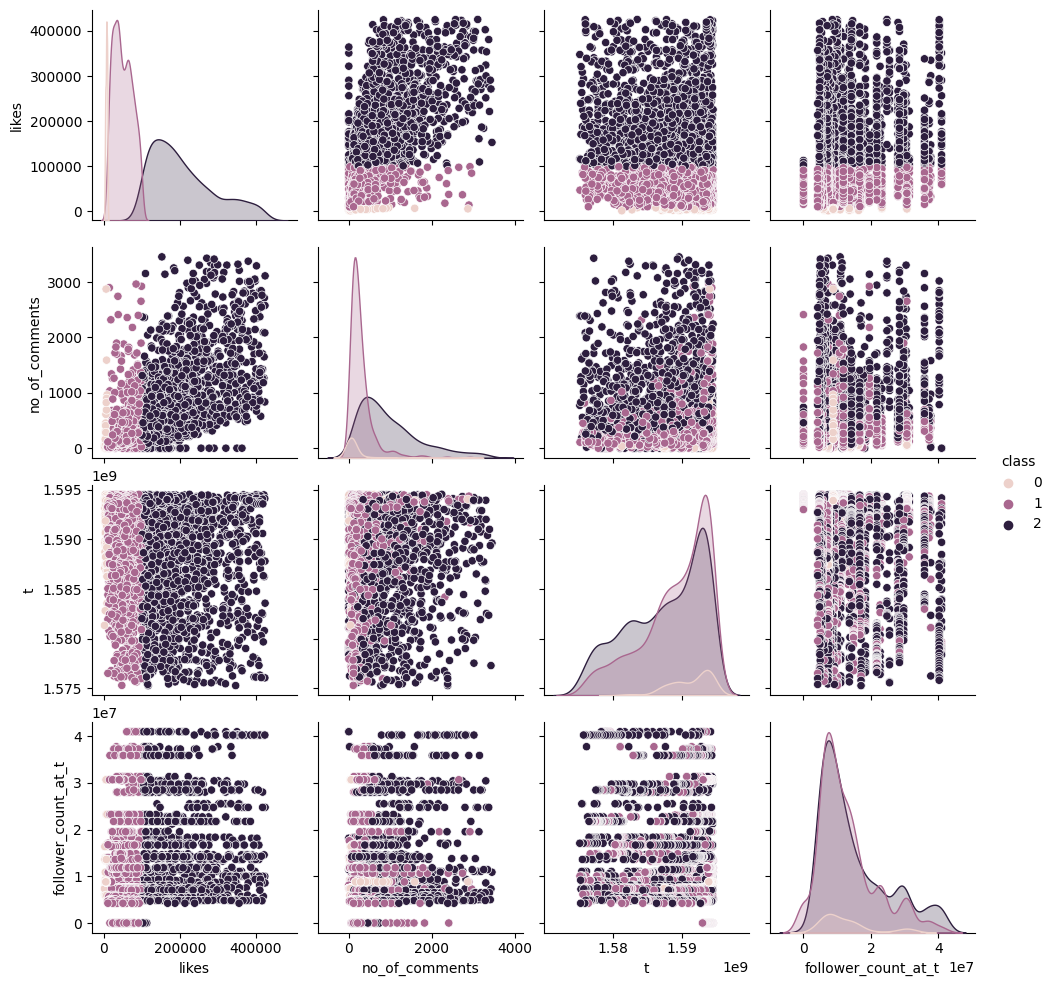

In [5]:
sns.pairplot(new_instagram_df, hue='class')

In [6]:
def open_image(image_path):
    return image_path, image.img_to_array(image.load_img(image_path, target_size=(224, 224)))

image_path_to_array = {}
with cf.ThreadPoolExecutor() as executor:
    futures = [executor.submit(open_image, image_path) for image_path in new_instagram_df['image_path']]
    for future in tqdm(cf.as_completed(futures), total=len(futures)):
        image_path, image_array = future.result()
        image_path_to_array[image_path] = image_array

  0%|          | 0/2955 [00:00<?, ?it/s]

## Generate Datasets

In [7]:
def get_X_Y_torch(df, image_path_to_array):
    X = []
    Y = []
    meta = []
    for _, row in df.iterrows():
        image_path = row['image_path']
        meta.append([row['follower_count_at_t'], row['no_of_comments'], row['t']])
        X.append(np.transpose(image_path_to_array[image_path], [2, 0, 1]))
        Y.append(row['class'])
    meta = np.array(meta)
    return np.array(X), np.array(Y), meta

x, y, meta = get_X_Y_torch(new_instagram_df, image_path_to_array)
scaler = StandardScaler()
meta = scaler.fit_transform(meta)
indexes = np.arange(len(x))
x_train, x_test, i_train, i_test = train_test_split(x, indexes, test_size=0.2, random_state=42)
y_train = y[i_train]
y_test = y[i_test]
meta_train = meta[i_train]
meta_test = meta[i_test]
x = y = meta = None

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train).long(), torch.tensor(meta_train).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
x_train = y_train = None

test_dataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test).long(), torch.tensor(meta_test).float())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
x_test = y_test = None

## Convolutional Neural Network Class Implementation

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        ## Larger model
        # self.model1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=5, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(64, 64, kernel_size=7, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(3),
        #     nn.Conv2d(64, 64, kernel_size=7),
        #     nn.ReLU(), 
        #     nn.MaxPool2d(5),
        #     nn.Flatten(),
        #     nn.Linear(64 * 5 * 5, 100),
        #     nn.ReLU()
        # )

        # Smaller model
        self.model1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(64 * 34 * 34, 100),
            nn.ReLU()
        )
        
        self.model2 = nn.Sequential(
            nn.Linear(103, 3)
        )

        for layer in self.model1.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        for layer in self.model2.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self, x, meta):
        return self.model2(torch.cat([self.model1(x), meta], dim=1))

## Hyperparameters

In [9]:
lr = 1e-3
epochs = 50000

## Initialize CNN

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Using device: cuda


## Train CNN

Learning Rate: [0.001]
Epoch: 15, Train Loss: 0.6025784140503084, Train Accuracy: 76.56514382402707
Epoch: 15, Test Loss: 0.8488990115491968, Test Accuracy: 75.80372250423012


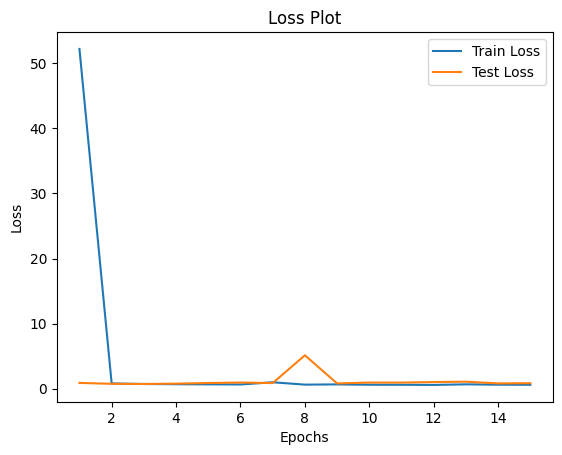

KeyboardInterrupt: 

In [11]:
fig = plt.figure()
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    
    net.train()
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0
    
    for x, y, meta in train_loader:
        
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        meta = meta.to(device)
        outputs = net(x, meta)
        predicted = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, y)
        train_running_loss += loss.item()
        loss.backward()
        nn_utils.clip_grad_norm_(net.parameters(), max_norm=10.0)
        optimizer.step()
        train_total += len(y)
        train_correct += (predicted == y).sum().item()
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {100 * train_correct / train_total}", end='\r')
    
    # scheduler.step()
    train_losses.append(train_running_loss/len(train_loader))
    
    net.eval()
    
    with torch.no_grad():
        
        test_correct = 0
        test_total = 0
        test_running_loss = 0.0
        
        for x, y, meta in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            meta = meta.to(device)
            outputs = net(x, meta)
            test_running_loss += criterion(outputs, y).item()
            predicted = torch.argmax(outputs, dim=1)
            test_total += len(y)
            test_correct += (predicted == y).sum().item()
    
    test_losses.append(test_running_loss/len(test_loader))

    clear_output(wait=True)
    print(f"Learning Rate: {scheduler.get_last_lr()}")
    print(f"Epoch: {epoch}, Train Loss: {train_running_loss/len(train_loader)}, Train Accuracy: {100 * train_correct / train_total}")
    print(f"Epoch: {epoch}, Test Loss: {test_running_loss/len(test_loader)}, Test Accuracy: {100 * test_correct / test_total}")
    plt.plot(range(1, epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Plot')
    plt.show()

    # if epoch % 1 == 0:
    #     torch.save(
    #         {
    #             'epoch': epoch,
    #             'model_state_dict': net.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'test_loss': test_losses[-1],
    #             'train_loss': train_losses[-1]  
    #         }, 
    #         f"models/model_{epoch}.pt"
    #     )
    #     fig.savefig(f"plots/plot_{epoch}.png")
        

## Predicition With Best Trained CNN

In [12]:
state_dict = torch.load("models/model_50.pt", weights_only=True)
trained_net = Net().to(device)
trained_net.load_state_dict(state_dict['model_state_dict'])
trained_net.eval()

with torch.no_grad():
    
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    for x, y, meta in test_loader:

        x = x.to(device)
        y = y.to(device)
        meta = meta.to(device)
        outputs = trained_net(x, meta)
        test_running_loss += criterion(outputs, y).item()
        predicted = outputs.max(dim=1)[1]
        test_total += len(y)
        test_correct += (predicted == y).sum().item()

print(f"Test Loss: {test_running_loss/len(test_loader)}, Test Accuracy: {100 * test_correct / test_total}")

Test Loss: 0.6215529363406332, Test Accuracy: 76.14213197969544
